# 01 Introduction to Machine Learning for Protein Engineering - Feed forward neural networks (FFNN)
---

In section 01 we will talk about the fundamentals of machine learning (ML), how they apply for protein engineering and how to implement them in ML frameworks like PyTorch. To begin with we are going to cover some theoretical foundations needed to understand what is happening in the code blocks. We are going to start by analyzing code simple code examples using toy datasets, before you will implement the same methods on biological data. 


In [1]:
import pandas as pd

wt_seq = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"
df = pd.read_csv('GB1_single_mutants.csv')
df

,description,sequence,fitness
0,Q2A,MAYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.518
1,Q2C,MCYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.024
2,Q2D,MDYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.911
3,Q2E,MEYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.952
4,Q2F,MFYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.617
...,...,...,...
1021,E56S,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.356
1022,E56T,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.410
1023,E56V,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.248
1024,E56W,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.301


## Encoding Protein Sequences: From Amino Acids to Numerical Data

When dealing with sequence in machine learning, we need to transform sequences into a numerical format before we can use them in our algorithms. We want to transform an amino acid sequences \\(S\\) to a numerical representation \\(\mathbf{X}\\) which can be interpreted by machine learning models. We can denote this as a mapping from \\(S\\) to \\(X\\):
   
   \\[S \rightarrow \mathbf{X}\\]

One prominent mapping method is _one-hot encoding_ (OHE). One-hot encoding a sequence means, that each unique character \\(s_i\\) of a sequence \\(S\\) is assigned to a vector \\(x_i\\) which is \\(0\\) in every position except for a single position where the vector has the value \\(1\\).

\\[
\text{OneHot}(s_i) = \begin{cases}
     1, & \text{if } s_i \text{ is the amino acid of interest} \\
     0, & \text{otherwise}
   \end{cases}
\\]

Here \\(s_i\\) represents an amino acid at position \\(i\\) in the sequence \\(S\\). One-hot encoding yields a binary vector \\(\mathbf{x}_i\\) for each amino acid \\(s_i\\), such that:

\\[\mathbf{x}_i = [0, 0, \ldots, 1, \ldots, 0]\\]

where the '\\(1\\)' occurs at the position corresponding to the amino acid in consideration, and all other elements are '\\(0\\)'. 

This results in a numerical matrix \\(\mathbf{X}\\) that represents \\(S\\) where each *row* corresponds to an amino acid position and each column represents a specific amino acid type. Thus:

\\[\mathbf{X}_{ij} = \text{OneHot}(s_i)_j\\]

### Questions
1. Why do you think that OHE is so poupular for representing sequences?
2. Why don't we simply encode each amino acid with a unique integer?
3. Can you think of any potential downsides for the representation method?
4. Analyze the following code segments, discuss what is happening.

### OHE implementation and visualization

In [2]:
import numpy as np

def one_hot_encode(seq):
    # Dictionary of standard amino acids
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

    # Initialize the one-hot encoded matrix
    one_hot = np.zeros((len(seq), len(amino_acids)), dtype=int)

    # Fill the matrix
    for i, aa in enumerate(seq):
        if aa in aa_to_int:
            one_hot[i, aa_to_int[aa]] = 1

    return one_hot

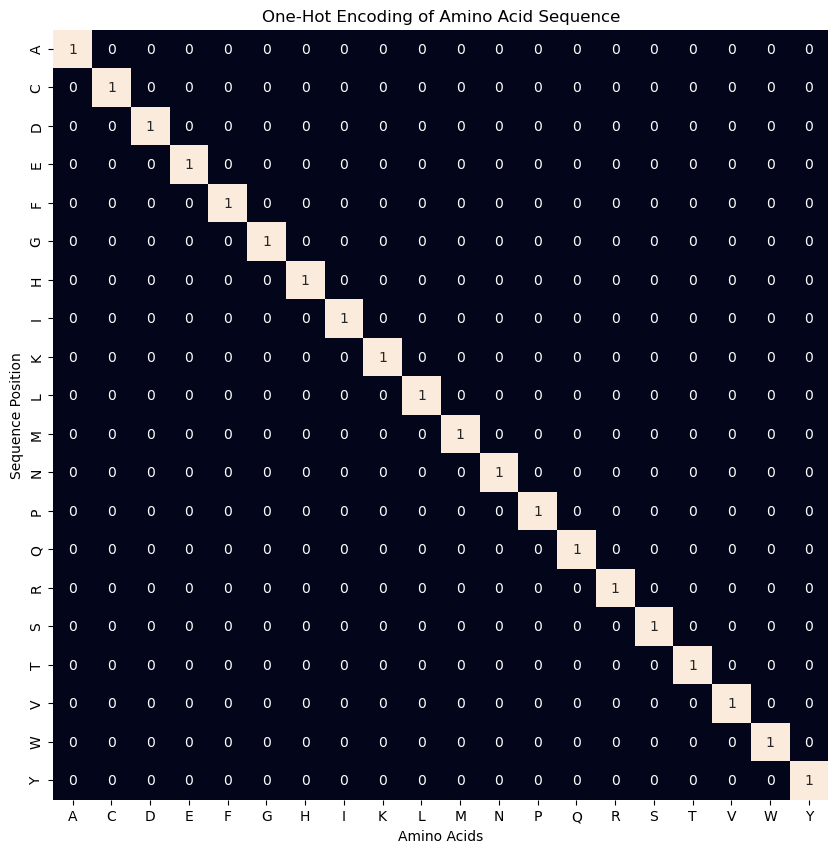

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_one_hot(encoded_seq, seq):
    # Create a heatmap from the one-hot encoded matrix
    plt.figure(figsize=(10, len(encoded_seq) / 2))
    sns.heatmap(encoded_seq, annot=True, cbar=False, cmap='rocket',
                xticklabels=list('ACDEFGHIKLMNPQRSTVWY'), yticklabels=list(seq))
    plt.xlabel('Amino Acids')
    plt.ylabel('Sequence Position')
    plt.title('One-Hot Encoding of Amino Acid Sequence')
    plt.show()

# Example usage
seq = "ACDEFGHIKLMNPQRSTVWY"
encoded_seq = one_hot_encode(seq)
visualize_one_hot(encoded_seq, seq)

In [4]:
def visualize_sequences(sequences):
    num_seqs = len(sequences)
    cols = min(num_seqs, 5)
    rows = (num_seqs - 1) // 5 + 1

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 2))

    for i, seq in enumerate(sequences):
        encoded_seq = one_hot_encode(seq)
        ax = axs[i // 5, i % 5] if rows > 1 else axs[i]
        
        sns.heatmap(encoded_seq, annot=True, cbar=False, cmap='rocket', ax=ax,
                    xticklabels=list('ACDEFGHIKLMNPQRSTVWY'), yticklabels=list(seq))
        ax.set_title(f'Sequence {i+1}')
        ax.set_xlabel('Amino Acids')
        ax.set_ylabel('Position')

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axs.flatten()[j])

    plt.tight_layout()
    plt.show()

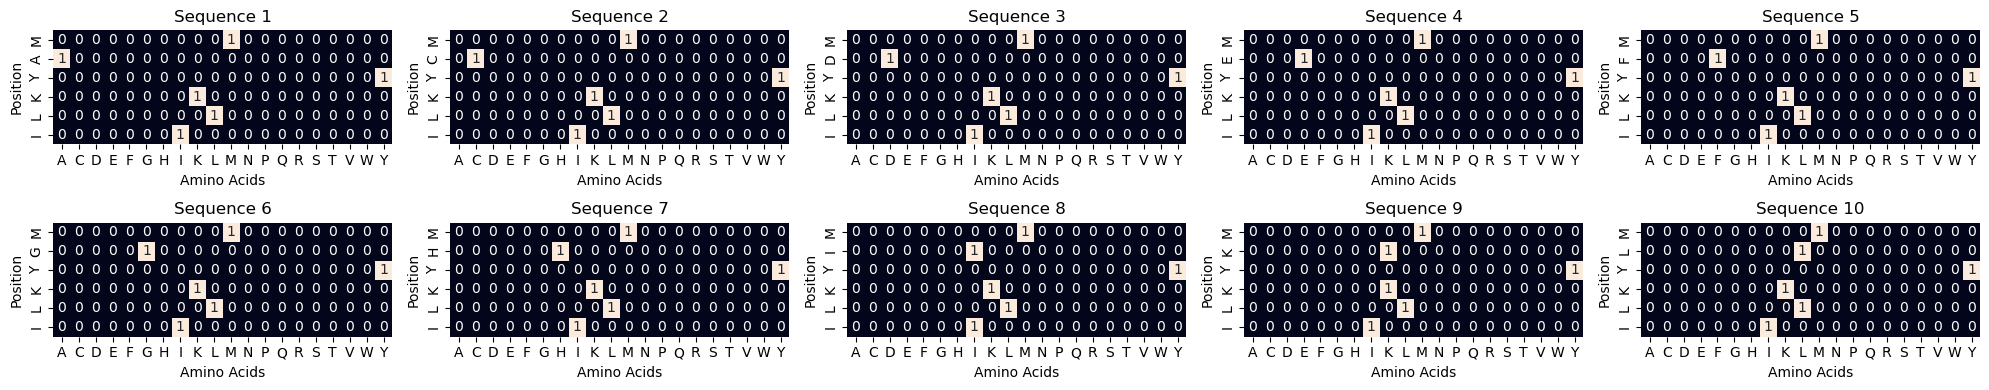

In [13]:
sequences = [seq[0:6] for seq in df.sequence.to_list()]
sequences = sequences[:10]

visualize_sequences(sequences) 

In [14]:
# encoding all sequences
df['encoded'] = df['sequence'].apply(one_hot_encode)

## Data Splitting

Data splitting involves dividing our dataset into three distinct sets:

1. **Training Set**: This set serves as the foundation for model training. 

2. **Testing Set**: This set remains untouched during training, and it's used to evaluate the model's performance after training. It's like a final exam for our model.

3. **Validation Set**: Think of this set as a quality control mechanism. It helps us fine-tune our model during training without tapping into the testing set. It's like a practice test before the final exam.

Splitting data is important to ensure that our model is not simply remembering the correct answers. By training on some parts of the data and testing on other parts of the data we can estimate how well the model would perform on unseen data.

1. **Model Assessment**: Data splitting allows us to assess how well our model performs on unseen data (testing set) and make necessary adjustments.

2. **Hyperparameter Tuning**: The validation set is crucial for fine-tuning model hyperparameters, ensuring that our model is optimized for the task.

### Questions
1. What would happen if we did not split data during training?


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

In [8]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, fitness_values):
        self.sequences = sequences
        self.fitness_values = fitness_values

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        fitness = self.fitness_values[idx]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(fitness, dtype=torch.float32)

# Prepare your dataset
X = np.stack(df['encoded'].values)
y = df['fitness'].values

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create datasets
train_dataset = SequenceDataset(X_train, y_train)
val_dataset = SequenceDataset(X_val, y_val)
test_dataset = SequenceDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Defining the model


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class FFNN(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(FFNN, self).__init__()

        # Create a list to hold all layers
        layers = []

        # Add the input layer
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())

        # Add hidden layers
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(nn.ReLU())

        # Add the output layer
        layers.append(nn.Linear(hidden_layers[-1], 1))

        # Register all layers
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [10]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for sequences, fitness in train_loader:
            sequences = sequences.view(sequences.size(0), -1)  # Flatten the sequences
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, fitness.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)  # Append to the list for Matplotlib
        #print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

        # Validation phase
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for sequences, fitness in val_loader:
                    sequences = sequences.view(sequences.size(0), -1)
                    outputs = model(sequences)
                    loss = criterion(outputs, fitness.unsqueeze(1))
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)  # Append to the list for Matplotlib


    # Plotting using Matplotlib
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

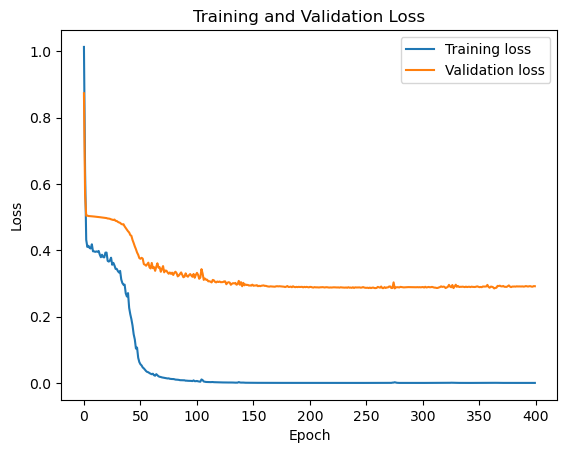

In [18]:
# Define the model Architecture
input_size = X_train.shape[1] * X_train.shape[2]  # num_amino_acids * len_sequence
model = FFNN(input_size, hidden_layers=[10, 10])

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=400)